## imports e declarações

In [52]:
#-*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
col = ["Abandono","Cancelamento","Classificado e Não Matriculado","Desligamento","Transferido"]

# Preparação, limpeza e agregação

## preparação e limpeza do dataset 1

In [2]:
def cleardb1(data):
    data.columns = data.loc[0]
    data.drop(data.index[:1], inplace=True)
    data.drop(data.index[-1], inplace=True)
    data["Campus"].fillna(method='ffill', inplace=True)
    data.rename({"NOME_CURSO": "curso", "Campus": "campus"}, axis=1, inplace=True)
    
    for i in col:
        if i not in data.columns:
            data[i] = np.nan
    for i in col:
        data[i].fillna(0, inplace=True)
    data.dropna(axis=1, inplace=True)
    
    data.reset_index(drop=True, inplace=True)

In [3]:
#carregando as databases e limpando com os metodos definidos anteriormente
d061 = pd.read_csv("./data/evasao - 061.csv", encoding = "utf-8")
cleardb1(d061)
d061.drop(columns=["Nº de alunos"], inplace=True)

d062 = pd.read_csv("./data/evasao - 062.csv", encoding = "utf-8")
cleardb1(d062)
d062.drop(columns=["Nº de alunos"], inplace=True)

d071 = pd.read_csv("./data/evasao - 071.csv", encoding = "utf-8")
cleardb1(d071)
d071.drop(columns=["Nº alunos"], inplace=True)

d072 = pd.read_csv("./data/evasao - 072.csv", encoding = "utf-8")
cleardb1(d072)
d072.drop(columns=["Nº de alunos"], inplace=True)

## preparação e limpeza do dataset 2

In [4]:
def cleardb2(data, lastline):
    data.columns = data.loc[1]
    data.drop(data.index[:2], inplace=True)
    data.drop(data.index[lastline], inplace=True)
    data["NOME_CURSO"].fillna(method='ffill', inplace=True)
    try:
        data["Campus"].fillna(method='ffill', inplace=True)
    except:
        pass
    data.dropna(1, inplace=True)
    data.reset_index(drop=True, inplace=True)
    data = split(data)
    data = pivoting(data)
    return data
    
def split(data):
    
    ocorrencia = data[["Ocorrência/forma de evasão"]]
    ocorrencia = pd.DataFrame(ocorrencia["Ocorrência/forma de evasão"].str.split("=").tolist())
    data = pd.concat([data, ocorrencia], axis=1, join_axes=[d081.index])
    
    data.drop(columns=["Ocorrência/forma de evasão"], inplace=True)
    data.rename({"NOME_CURSO": "curso", 0:"tipo", 1:"quantidade"}, axis=1, inplace=True)
    data.quantidade = data.quantidade.apply(pd.to_numeric)
    return data

def pivoting(data):
    data.dropna(inplace=True)
    data1 = data.pivot(index="curso", columns='tipo', values="quantidade")
    data1.fillna(0, inplace=True)
    data1.reset_index(inplace=True)
    if("Campus" in data):
        data.rename({"Campus":"campus"}, axis=1, inplace=True)
        data1 = pd.concat([data1, data.campus], axis=1)
    else:
        data["campus"] = pd.Series(['' for i in range(len(data['curso']))])
        data1 = pd.concat([data1, data.campus], axis=1)
    data1.dropna(axis=0, inplace=True)
    return data1

In [5]:
#carregando as databases e limpando com os metodos definidos anteriormente
d081 = pd.read_csv("./data/evasao - 081.csv", encoding = "utf-8")
d081 = cleardb2(d081,-4)

d082 = pd.read_csv("./data/evasao - 082.csv", encoding = "utf-8")
d082 = cleardb2(d082, -5)

d091 = pd.read_csv("./data/evasao - 091.csv", encoding = "utf-8")
d091 = cleardb2(d091, -8)

d092 = pd.read_csv("./data/evasao - 092.csv", encoding = "utf-8")
d092 = cleardb2(d092, -6)

d101 = pd.read_csv("./data/evasao - 101.csv", encoding = "utf-8")
d101 = cleardb2(d101, -8)

d102 = pd.read_csv("./data/evasao - 102.csv", encoding = "utf-8")
d102 = cleardb2(d102,-7)

d111 = pd.read_csv("./data/evasao - 111.csv", encoding = "utf-8")
d111 = cleardb2(d111,-5)

In [6]:
#com base com todas as planilhas anteriores pega todos os cursos e seus campus
datasets = [d061[["curso", "campus"]],d062[["curso", "campus"]],d071[["curso", "campus"]],d072[["curso", "campus"]],
            d081[["curso", "campus"]],d082[["curso", "campus"]],d091[["curso", "campus"]],d092[["curso", "campus"]],
            d101[["curso", "campus"]],d102[["curso", "campus"]],d111[["curso", "campus"]]]

cursos = pd.concat(datasets)
cursos = cursos[cursos.campus != '']
cursos.drop_duplicates(inplace=True)
cursos.sort_values(by="campus", inplace=True)
cursos.reset_index(drop=True, inplace=True)

## finalizando a limpesa dos datasets agregando o campus na tabela dos cursos

In [7]:
datasets = [d061,d062,d071,d072,d081,d082,d091,d092,d101,d102,d111]    

for i in range(len(datasets)):
    datasets[i].columns = datasets[i].columns.str.lower()
    if("campus" in datasets[i]):
        datasets[i].drop(columns=["campus"], inplace=True)
    datasets[i] = pd.merge(datasets[i], cursos, left_on="curso", right_on="curso")
    datasets[i].sort_values(by="campus", inplace=True)
    
for i in range(len(datasets)):
    if("transferência" in datasets[i]):
        if("transferência interna" in datasets[i]):
            datasets[i]["transferência"] += datasets[i]["transferência interna"]
            datasets[i].drop("transferência interna", axis=1, inplace=True)
        if("transferido" in datasets[i]):
            datasets[i]["transferência"] += datasets[i]["transferido"]
            datasets[i].drop("transferido", axis=1, inplace=True)
    else:
        datasets[i].rename(columns={"transferido": "transferência"},inplace=True)
    if("classificado e não matriculado" in datasets[i]):
        if("sem matrícula" in datasets[i]):
            datasets[i]["classificado e não matriculado"] += datasets[i]["sem matrícula"]
            datasets[i].drop("sem matrícula", axis=1, inplace=True)
            

## agregando todas as tabelas por semestre

In [8]:
keys = ["2006.1", "2006.2", "2007.1", "2007.2", "2008.1", "2008.2", "2009.1", "2009.2", "2010.1", "2010.2", "2011.1"]
datasets = pd.concat(datasets, keys=keys)
datasets = datasets.fillna(0)
datasets = datasets.apply(pd.to_numeric, errors='ignore')

# Respostas para as perguntas:

### Qual as cidades com o maior indice de evasões?

As duas cidades com maior indice de evasão são Bagé com 44.44% e Alegrete com 32.15% do total de evasões do primeiro semestre de 2006 até o primeiro semestre de 2011, como pode ser visto a baixo, na tabela e no grafico.

In [60]:
cidades = datasets.groupby("campus").sum().sum(axis=1).sort_values(ascending=False)
cidades

campus
Bagé                     806.0
Alegrete                 583.0
Caçapava do Sul           85.0
São Borja                 80.0
São Gabriel               77.0
Uruguaiana                68.0
Jaguarão                  45.0
Itaqui                    32.0
Santana do Livramento     20.0
Dom Pedrito               17.0
dtype: float64

In [70]:
cidades.sum()

1813.0

<BarContainer object of 10 artists>

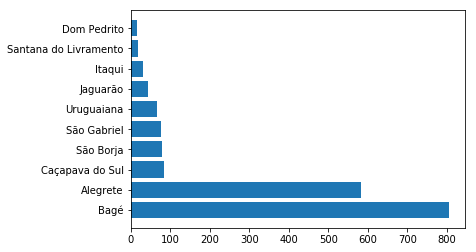

In [62]:
barh(cidades.index, cidades.values)

In [71]:
cidades.Bagé/cidades.sum()*100

44.45670159955874

In [72]:
cidades.Alegrete/cidades.sum()*100

32.156646442360724